In [2]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

### AUGMENTATIONS

In [3]:
split_layer = 2
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

In [119]:
for batch in trainloader:
    print(batch[0].shape)
    break

torch.Size([64, 1, 28, 28])


In [70]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)

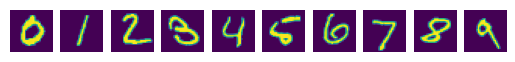

In [71]:
ims = [get_examples_by_class(testset, c, count=1) for c in range(10)]
display_imagelist(ims, 28, 28)

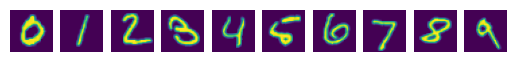

In [77]:
COUNT = 1

inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 32, 32)

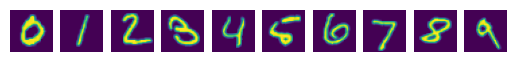

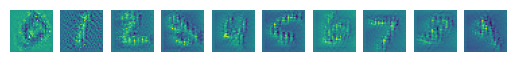

In [38]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

In [39]:
augmented_trasnforms = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)

In [42]:
augmented_testset[0][0].shape

torch.Size([1, 64, 64])

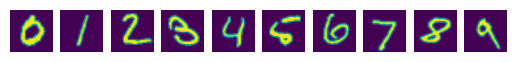

In [43]:
COUNT = 1
inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
display_imagelist(inversion_targets, 64, 64)

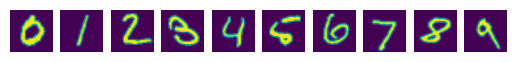

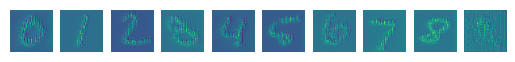

In [44]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 64, 64) # 28 28
    display_imagelist(results, 64, 64) # 28 28

#### with training

In [47]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.32459959387779236 Acc: 96.69785360484315
Epoch: 1 Loss: 0.08627594262361526 Acc: 97.57575757575758
Epoch: 2 Loss: 0.06092633306980133 Acc: 98.19672131147541
Epoch: 3 Loss: 0.04698646441102028 Acc: 98.00108049702864
Epoch: 4 Loss: 0.03844796121120453 Acc: 98.46322722283205
Epoch: 5 Loss: 0.03173432871699333 Acc: 98.39779005524862
Epoch: 6 Loss: 0.028777405619621277 Acc: 98.51485148514851
Epoch: 7 Loss: 0.023382358253002167 Acc: 98.47991313789359
Epoch: 8 Loss: 0.021692944690585136 Acc: 99.34029686641011
Epoch: 9 Loss: 0.0175878144800663 Acc: 98.7417943107221


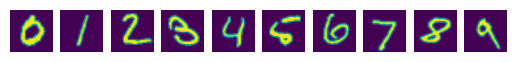

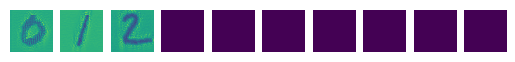

In [48]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 64, 64) # 28 28
    display_imagelist(results, 64, 64) # 28 28

print(f"Average MSE: {sum(losses) / len(losses)}")
print(f"Clone test score: {get_test_score(client, clone, augmented_testset, split=split_layer)}%")

In [51]:
print(f"Average MSE: {sum(losses) / len(losses)}")

Average MSE: 0.10147987306118011


In [53]:
print(f"Clone test score: {get_test_score(client, clone, testset, split=split_layer)}%")

Clone test score: 10.534934497816593%


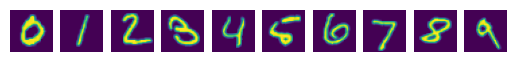

In [50]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)
COUNT = 1
inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
display_imagelist(inversion_targets, 32, 32)

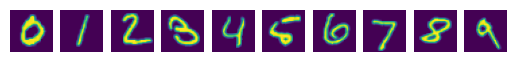

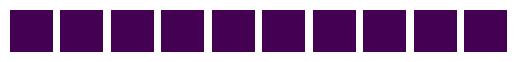

In [56]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

In [57]:
print(f"Average MSE: {sum(losses) / len(losses)}")
print(f"Clone test score: {get_test_score(client, clone, testset, split=split_layer)}%")

Average MSE: 0.09928103536367416
Clone test score: 10.905125408942203%


In [60]:
results[0]

tensor([[[[3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          ...,
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40],
          [3.2175e-40, 3.2175e-40, 3.2175e-40,  ..., 3.2175e-40,
           3.2175e-40, 3.2175e-40]]]])

normal example

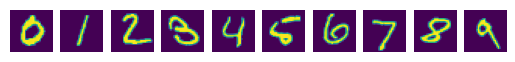

In [73]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
display_imagelist(inversion_targets, 28, 28)

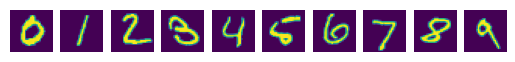

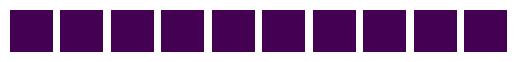

In [67]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28) # 28 28
    display_imagelist(results, 28, 28) # 28 28

In [76]:
for i, t in enumerate(targetloader):
    print(t.size())
    break

torch.Size([1, 1, 28, 28])


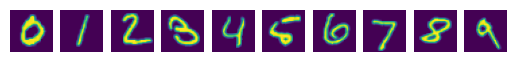

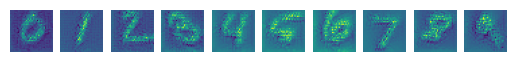

In [82]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out,  torch.Size([1, 1, 32, 32]), main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

## scale the results

In [86]:
def display_imagelist(images, height, width, count=1):
    fig, ax = plt.subplots(count, len(images)) #1
    if count == 1:
        for index, image in enumerate(images):
            ax[index].axis('off')
            ax[index].imshow(image.cpu().detach().reshape(height, width))
    else:
        for id, nested in enumerate(images):
            for index, image in enumerate(nested):
                ax[index, id].axis('off')
                ax[index, id].imshow(image.cpu().detach().reshape(height, width))
    plt.show()

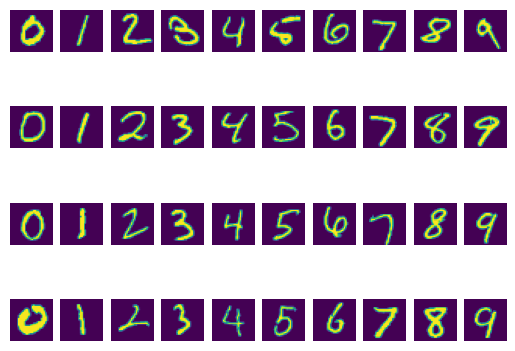

In [96]:
COUNT = 4

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28, count=COUNT)

1. without defense

In [91]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.30646786093711853 Acc: 97.76444929116686
Epoch: 1 Loss: 0.08359634876251221 Acc: 97.1978021978022
Epoch: 2 Loss: 0.058322470635175705 Acc: 97.9291553133515
Epoch: 3 Loss: 0.044857464730739594 Acc: 98.29389102916896
Epoch: 4 Loss: 0.035468097776174545 Acc: 98.90350877192982
Epoch: 5 Loss: 0.03051494061946869 Acc: 98.63088718510406
Epoch: 6 Loss: 0.02515879087150097 Acc: 99.23622476813966
Epoch: 7 Loss: 0.021994834765791893 Acc: 99.34640522875817
Epoch: 8 Loss: 0.019342243671417236 Acc: 99.1140642303433
Epoch: 9 Loss: 0.015787361189723015 Acc: 98.7250554323725


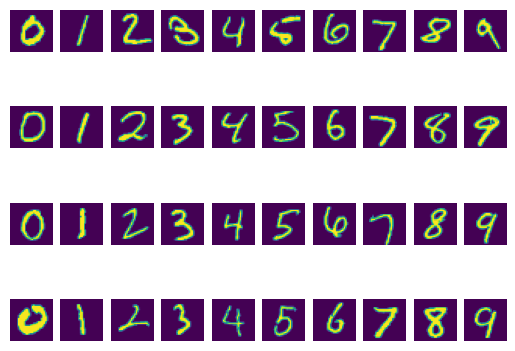

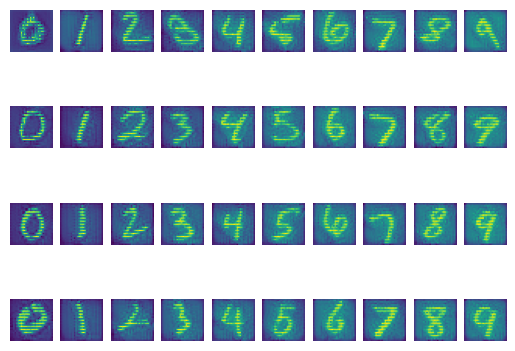

In [98]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

In [99]:
client, server, clone = MnistNet(), MnistNet(), MnistNet()

client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.30740001797676086 Acc: 96.86813186813187
Epoch: 1 Loss: 0.08596665412187576 Acc: 98.39156960621187
Epoch: 2 Loss: 0.05998585373163223 Acc: 98.74041621029573
Epoch: 3 Loss: 0.047614771872758865 Acc: 98.6870897155361
Epoch: 4 Loss: 0.03775125741958618 Acc: 98.90049477735019
Epoch: 5 Loss: 0.03099769912660122 Acc: 99.06593406593407
Epoch: 6 Loss: 0.027923399582505226 Acc: 98.8962472406181
Epoch: 7 Loss: 0.023314794525504112 Acc: 98.84805266044981
Epoch: 8 Loss: 0.019866708666086197 Acc: 99.23580786026201
Epoch: 9 Loss: 0.018212301656603813 Acc: 99.06644700713893


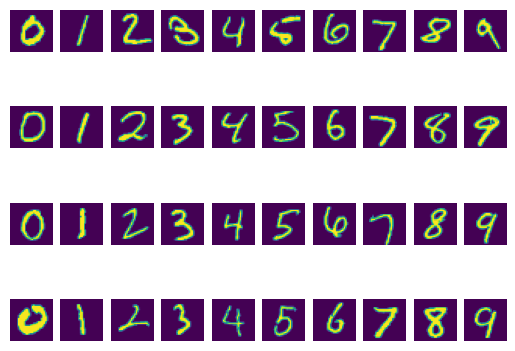

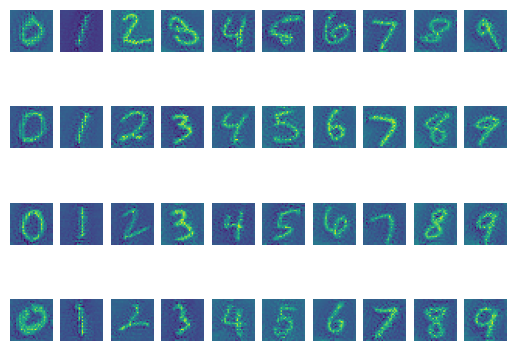

In [100]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

2. with augmentation defense

In [108]:
clone_model_2 = MnistNet()

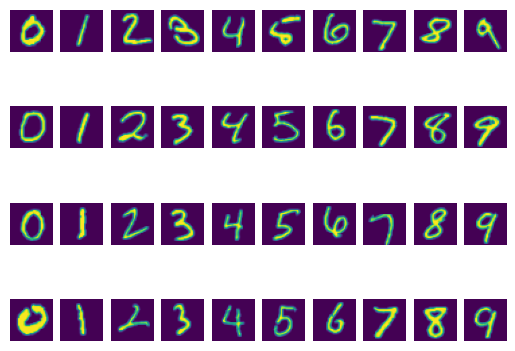

In [102]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)
COUNT = 4
aug_inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(aug_inversion_targets, shuffle=False)
display_imagelist(aug_inversion_targets, 32, 32, count=COUNT)

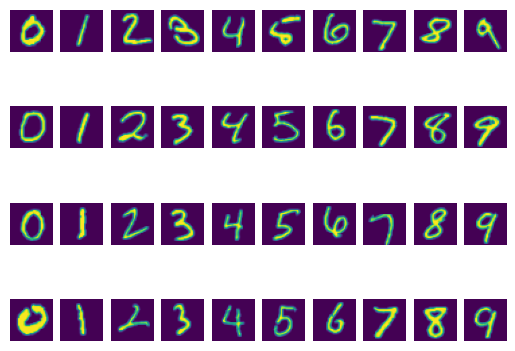

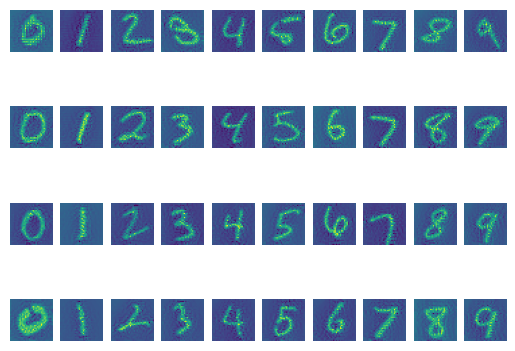

In [109]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(augmented_targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        # perform the attack
        result = unsplit.model_inversion_stealing(clone_model_2, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone_model_2, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

if dataset == 'cifar':
    display_cifar(aug_inversion_targets)
    display_cifar(results)
else:
    display_imagelist(aug_inversion_targets, 32, 32, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 32, 32, count=COUNT)

64 64

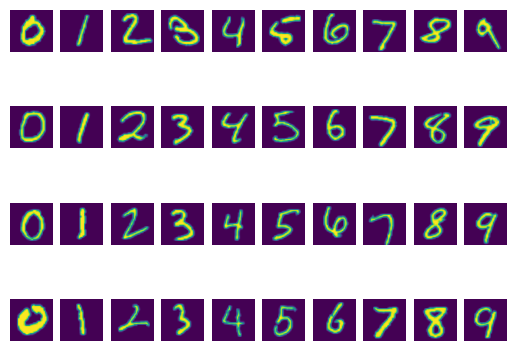

In [110]:
augmented_trasnforms = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)
COUNT = 4
aug_inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(aug_inversion_targets, shuffle=False)
display_imagelist(aug_inversion_targets, 64, 64, count=COUNT)

In [111]:
client, server, clone = MnistNet(), MnistNet(), MnistNet()

client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.29285308718681335 Acc: 97.69989047097481
Epoch: 1 Loss: 0.07784289866685867 Acc: 98.3633387888707
Epoch: 2 Loss: 0.05404689535498619 Acc: 98.39513004980631
Epoch: 3 Loss: 0.04174082353711128 Acc: 98.23691460055096
Epoch: 4 Loss: 0.035287536680698395 Acc: 98.95547003848269
Epoch: 5 Loss: 0.029522139579057693 Acc: 98.90470974808325
Epoch: 6 Loss: 0.024650946259498596 Acc: 98.9685124864278
Epoch: 7 Loss: 0.02168140560388565 Acc: 98.95890410958904
Epoch: 8 Loss: 0.0166583564132452 Acc: 98.64351600651112
Epoch: 9 Loss: 0.015616925433278084 Acc: 99.33811362382791


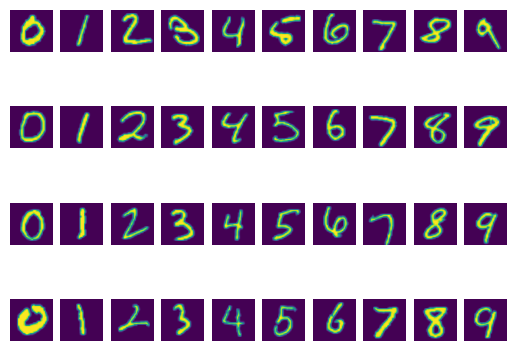

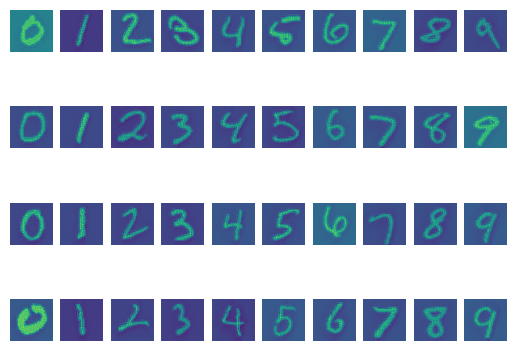

In [112]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(augmented_targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

if dataset == 'cifar':
    display_cifar(aug_inversion_targets)
    display_cifar(results)
else:
    display_imagelist(aug_inversion_targets, 64, 64, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 64, 64, count=COUNT)

если не получится взять другой лоадер и запустить с этими же моделями на нем (32 32)

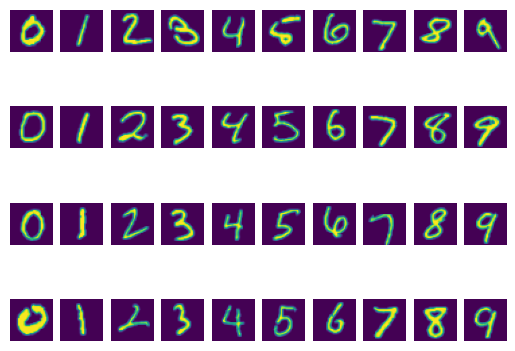

In [113]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)
COUNT = 4
aug_inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(aug_inversion_targets, shuffle=False)
display_imagelist(aug_inversion_targets, 32, 32, count=COUNT)

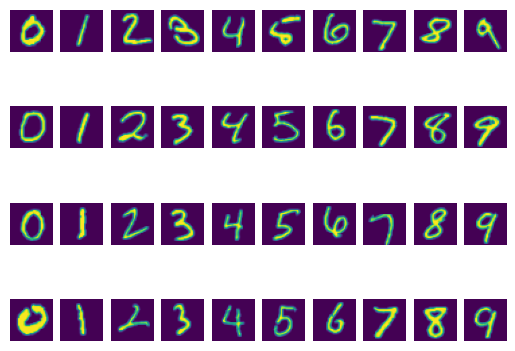

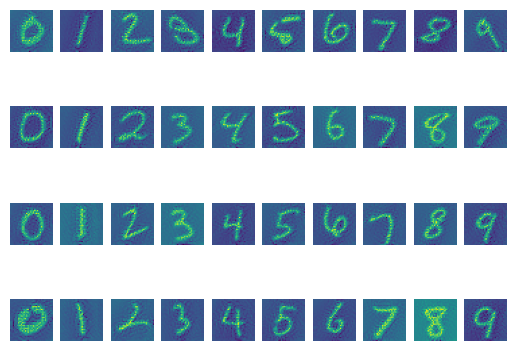

In [116]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(augmented_targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

if dataset == 'cifar':
    display_cifar(aug_inversion_targets)
    display_cifar(results)
else:
    display_imagelist(aug_inversion_targets, 32, 32, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 32, 32, count=COUNT)

test: delete then

In [120]:
augmented_trasnforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
augmented_testset = datasets.MNIST('data/mnist', download=True, train=False, transform=augmented_trasnforms)

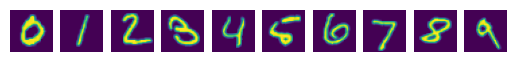

In [121]:
COUNT = 1
inversion_targets = [get_examples_by_class(augmented_testset, c, count=COUNT) for c in range(10)]
augmented_targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()
display_imagelist(inversion_targets, 32, 32)

In [122]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')

Epoch: 0 Loss: 0.3051680028438568 Acc: 97.3047304730473
Epoch: 1 Loss: 0.0855008140206337 Acc: 98.21621621621621
Epoch: 2 Loss: 0.060244299471378326 Acc: 98.72151195108394
Epoch: 3 Loss: 0.04784546047449112 Acc: 99.17309812568908
Epoch: 4 Loss: 0.03888249769806862 Acc: 98.74110563765736
Epoch: 5 Loss: 0.03332190215587616 Acc: 99.23954372623574
Epoch: 6 Loss: 0.027423664927482605 Acc: 98.90170236133993
Epoch: 7 Loss: 0.02528727985918522 Acc: 98.72787610619469
Epoch: 8 Loss: 0.022011158987879753 Acc: 99.12472647702407
Epoch: 9 Loss: 0.02041693404316902 Acc: 99.28137092316197


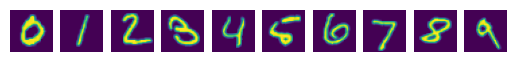

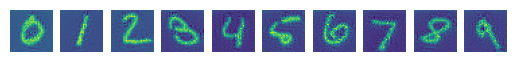

In [124]:
results, losses = [], []
for idx, target in enumerate(augmented_targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 32, 32) # 28 28
    display_imagelist(results, 32, 32) # 28 28

In [7]:
for batch in trainloader:
    print(batch[0].shape)
    break

torch.Size([64, 1, 28, 28])


In [8]:
client

MnistNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (ReLU1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (ReLU2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1act): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2act): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)